In [6]:
df = pd.read_csv('data/ozone.csv')
df

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5
...,...,...,...,...,...,...
148,30.0,193.0,6.9,70,9,26
149,NaN,145.0,13.2,77,9,27
150,14.0,191.0,14.3,75,9,28
151,18.0,131.0,8.0,76,9,29


In [7]:
# 온도에 따른 Ozone량 예측

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats     # 이상치 처리를 위해서 필요
import tensorflow as tf     # tensorflow 구현
from sklearn import linear_model  # sklearn으로 simple linear regression 구현
from sklearn.preprocessing import MinMaxScaler # normalization 전처리


# Raw Data Loading
df = pd.read_csv('data/ozone.csv')
training_data = df[['Temp','Ozone']]   # 153 rows × 2 columns

# 결측치부터 처리해 보아요!
# 결측치를 찾아서 제거할꺼예요!
training_data = training_data.dropna(how='any')
# display(training_data)    # 116 rows × 2 columns

# 이상치 처리(outlier)
# z-score를 이용해서 outlier를 처리
zscore_threshold = 1.8

# Temp에 대한 outlier(지대점)
tmp = ~(np.abs(stats.zscore(training_data['Temp'])) > zscore_threshold)
training_data = training_data.loc[tmp]
# display(training_data)   # 110 rows × 2 columns

# Ozone에 대한 outlier
tmp = ~(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)
training_data = training_data.loc[tmp]
# display(training_data)   # 103 rows × 2 columns

###########################
# 정규화 처리를 진행(Min-Max Scaler)
# 직접구현해도 되지만 sklearn을 이용해서 처리해 보아요!

# Min-Max Scaler라고 불리는 객체를 생성
# 이 객체를 두개 만들꺼예요! 독립변수와 종속변수에 대해서 각각 만들어줘요!
scaler_x = MinMaxScaler()  # 객체 생성
scaler_t = MinMaxScaler()  # 객체 생성
scaler_x.fit(training_data['Temp'].values.reshape(-1,1))
scaler_t.fit(training_data['Ozone'].values.reshape(-1,1))
# print(scaler_x.n_samples_seen_, scaler_x.data_max_, 
#       scaler_x.data_min_, scaler_x.feature_range)
training_data['Temp'] = scaler_x.transform(training_data['Temp'].values.reshape(-1,1))
training_data['Ozone'] = scaler_t.transform(training_data['Ozone'].values.reshape(-1,1))

display(training_data)


# Training Data Set
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

# placeholder
X = tf.placeholder(shape=[None,1], dtype=tf.float32)
T = tf.placeholder(shape=[None,1], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([1,1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='bias')

# Hypothesis
H = tf.matmul(X,W) + b

# loss function
loss = tf.reduce_mean(tf.square(H-T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# session, 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train, W, b, loss], 
                                         feed_dict={X: x_data, T: t_data})
    
    if step % 30000 == 0:
        print('W : {}, b : {}, loss : {}'.format(W_val,b_val,loss_val))

        

,Temp,Ozone
0,0.181818,0.397849
1,0.333333,0.344086
2,0.393939,0.086022
3,0.030303,0.150538
5,0.151515,0.258065
...,...,...
147,0.060606,0.107527
148,0.272727,0.279570
150,0.424242,0.107527
151,0.454545,0.150538


W : [[-1.3211684]], b : [0.18333265], loss : 1.0354580879211426
W : [[-0.47696403]], b : [0.6312814], loss : 0.13936182856559753
W : [[-0.1334948]], b : [0.44808203], loss : 0.08843272924423218
W : [[0.11710739]], b : [0.3140935], loss : 0.061292026191949844
W : [[0.300046]], b : [0.21628368], loss : 0.04682869464159012
W : [[0.43359292]], b : [0.14488095], loss : 0.039120957255363464
W : [[0.53108525]], b : [0.09275599], loss : 0.03501332551240921
W : [[0.6022315]], b : [0.05471157], loss : 0.032824885100126266
W : [[0.6541751]], b : [0.02694186], loss : 0.031658414751291275
W : [[0.69206965]], b : [0.00667248], loss : 0.0310369860380888


In [8]:
# sklearn을 이용해서 구현해 보아요!
# Training Data Set
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

model = linear_model.LinearRegression()
model.fit(x_data,t_data)

print('W : {}, b : {}'.format(model.coef_, model.intercept_))

W : [[0.79468511]], b : [-0.04818192]


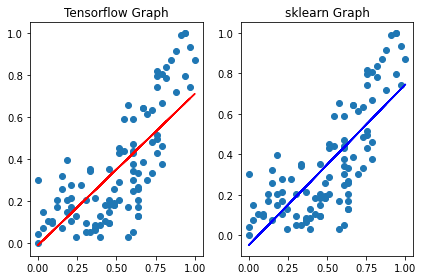

In [9]:
# Graph로 비교해 보아요!!
fig = plt.figure()
fig_tensorflow = fig.add_subplot(1,2,1)
fig_sklearn = fig.add_subplot(1,2,2)

fig_tensorflow.set_title('Tensorflow Graph')
fig_sklearn.set_title('sklearn Graph')

fig_tensorflow.scatter(x_data,t_data)
fig_tensorflow.plot(x_data,x_data*W_val.ravel() + b_val, color='r')

fig_sklearn.scatter(x_data,t_data)
fig_sklearn.plot(x_data,x_data*model.coef_.ravel() + model.intercept_, color='b')

fig.tight_layout()
plt.show()



In [10]:
# prediction
# 온도가 62도 일때 Ozone은 얼마일까요??

# sklearn을 이용
sklearn_result = model.predict([[62]])
print(sklearn_result)    # [[49.22229492]]

# tensorflow를 이용
tensorflow_result = sess.run(H, feed_dict={X:[[62]]})
print(tensorflow_result)

[[49.22229492]]
[[44.615223]]


In [12]:
# Multiple Linear Regression
# 온도, 태양광세기, 바람세기을 이용하여 Ozone량을 예측

import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model

# Raw Data Loading
df = pd.read_csv('data/ozone.csv')

# 학습에 필요한 데이터부터 추출
training_data = df[['Temp','Wind','Solar.R','Ozone']]
# display(training_data)   # 153 rows × 4 columns

# 결측치 처리
training_data = training_data.dropna(how='any')
# display(training_data) # 111 rows × 4 columns

# 이상치 처리
zscore_threshold = 1.8

for col in training_data.columns:
    tmp = ~(np.abs(stats.zscore(training_data[col])) > zscore_threshold)
    training_data = training_data.loc[tmp]

#display(training_data)   # (86, 4)

# 정규화 처리
scaler_x = MinMaxScaler()  # 객체 생성
scaler_t = MinMaxScaler()  # 객체 생성
scaler_x.fit(training_data[['Temp','Wind','Solar.R']].values)
scaler_t.fit(training_data['Ozone'].values.reshape(-1,1))

training_data_x = scaler_x.transform(training_data[['Temp','Wind','Solar.R']].values)
training_data_t = scaler_t.transform(training_data['Ozone'].values.reshape(-1,1))

# Tensorflow 코드

# placeholder
X = tf.placeholder(shape=[None,3], dtype=tf.float32)
T = tf.placeholder(shape=[None,1], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([3,1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='bias')

# Hypothesis
H = tf.matmul(X,W) + b

# loss function
loss = tf.reduce_mean(tf.square(H-T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# session, 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train, W, b, loss], 
                                         feed_dict={X: training_data_x, 
                                                    T: training_data_t})
    
    if step % 30000 == 0:
        print('W : {}, b : {}, loss : {}'.format(W_val,b_val,loss_val))

    

W : [[ 0.16513167]
 [-0.7956374 ]
 [ 0.9990923 ]], b : [-0.42478362], loss : 0.3634781837463379
W : [[ 0.42329592]
 [-0.5678284 ]
 [ 0.8643045 ]], b : [-0.07999441], loss : 0.05983595550060272
W : [[ 0.50056326]
 [-0.5038958 ]
 [ 0.6585668 ]], b : [-0.03518764], loss : 0.04151173681020737
W : [[ 0.5561378 ]
 [-0.45837918]
 [ 0.5149762 ]], b : [-0.0052506], loss : 0.03252460062503815
W : [[ 0.5962481 ]
 [-0.42579237]
 [ 0.4148031 ]], b : [0.01449194], loss : 0.0281123835593462
W : [[ 0.62532556]
 [-0.40230712]
 [ 0.3449701 ]], b : [0.02728049], loss : 0.025943251326680183
W : [[ 0.64647526]
 [-0.38526744]
 [ 0.2963292 ]], b : [0.03535306], loss : 0.024874983355402946
W : [[ 0.6620108 ]
 [-0.37281173]
 [ 0.26247922]], b : [0.04025253], loss : 0.024346966296434402
W : [[ 0.67345023]
 [-0.36363205]
 [ 0.23896332]], b : [0.04305747], loss : 0.02408510260283947
W : [[ 0.68178266]
 [-0.3567774 ]
 [ 0.22265044]], b : [0.04450587], loss : 0.02395470254123211


In [13]:
# 예측값을 한번 구해보아요!!
# tensorflow를 이용해서 만든 모델로 예측값을 구하고
# sklearn으로 구현한 모델을 이용해서 예측값을 구해서 
# 값을 비교해 보아요!
# 예측을 할 값은 => (온도, 바람, 태양광세기) => [80,10,150])
# ???
predict_data = np.array([[80,10,150]])
scaled_predict_data = scaler_x.transform(predict_data)

tensorflow_result = sess.run(H, feed_dict={X:scaled_predict_data})

tensorflow_result = scaler_t.inverse_transform(tensorflow_result)

print(tensorflow_result)

[[38.30634]]


In [14]:
model = linear_model.LinearRegression()
# model.fit(training_data_x,training_data_t)
model.fit(training_data[['Temp','Wind','Solar.R']].values,
         training_data['Ozone'].values.reshape(-1,1))

# sklearn은 머신러닝내용을 모르는 사람도 데이터를 쉽게 학습해서
# 예측값을 알아낼 수 있도록 모듈화 시켜서 우리에게 제공!

# print('W : {}, b : {}'.format(model.coef_, model.intercept_))
print(model.predict([[80.0,10.0,150.0]]))

[[38.8035437]]
